## IMPORT LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.stats import spearmanr, pointbiserialr, chi2_contingency

## LOADING DATA

In [4]:
file_name="./data/Input_data.csv"
df = pd.read_csv(file_name)
df.shape

(14506, 21)

## ADDING COLUMNS

In [6]:
# adding combined column (connecting two)
def combine_columns(df, col1, col2, new_col_name):
    df[new_col_name] = df[col1].astype(str) + "_" + df[col2].astype(str)
    return df

df = combine_columns(df, "type", "subtype", "property_type")
df.shape

(14506, 22)

## DROPPING DATA 

### Dropping duplicates

In [9]:
df = df.drop(columns='property_ID')
def drop_duplicates_df(df, subset=None, keep="first", reset_index=True):
    df_clean = df.drop_duplicates(subset=subset, keep=keep)
    if reset_index:
        df_clean = df_clean.reset_index(drop=True)
    return df_clean

df = drop_duplicates_df(df)
df.shape

(14506, 21)

### Dropping columns

In [11]:
# Elimination of the least informative variables
cols_to_drop = ['locality_name','type','subtype','open_fire','terrace_area','number_facades','state_of_building','price_per_m2','municipality','province','region']
df = df.drop(columns=cols_to_drop) 
df.shape


(14506, 10)

### Searching / Dropping similar rows (with 1 difference)

In [13]:
# It is not recommended to run this function every time, as it takes a very long time to execute.
# This function was used separately to identify rows with only one difference and then evaluate whether two rows are likely duplicates.
# It is recommended to run it on a small sample before running it on the entire array.
# For example, this revealed that there were many similar rows for new apartments,so a separate csv file without new apartments was created to analyze duplicates.
import os
from itertools import combinations

def find_similar_rows(df, file_name=None):
    rows = []
    cols = df.columns

    # We go through all pairs of lines (i < j)
    for i, j in combinations(df.index, 2):
        diff_cols = (df.loc[i] != df.loc[j])

        # We count the number of differences
        if diff_cols.sum() == 1:
            col_name = cols[diff_cols.argmax()]  # название отличающегося столбца

            rows.append({
                "row_i": i,
                "row_j": j,
                "different_column": col_name,
                "value_i": df.loc[i, col_name],
                "value_j": df.loc[j, col_name],
                "row_i_data": df.loc[i].to_dict(),
                "row_j_data": df.loc[j].to_dict()
            })

    df_similar = pd.DataFrame(rows)

    # Save CSV if file specified
    if file_name is not None:
        name, ext = os.path.splitext(file_name)
        new_file = f"{name}_similar_rows.csv"
        df_similar.to_csv(new_file, index=False)

    return df_similar

# df_similar = find_similar_rows(df, file_name=file_name)

### Dropping rows by condition

In [15]:
# Dropping outliers
df = df[df['living_area'] <= 1000] # exclude property with living_area > 1000 m2 (22 objects = 0,15%)
df.shape

(14484, 10)

## PREPROCESSING

### Determining data fullness

In [18]:
def missing_info(df):
    total = len(df)
    missing = df.isna().sum()
    filled_pct = (1 - missing / total) * 100

    result = pd.DataFrame({
        "missing_count": missing,
        "filled_percent": filled_pct.round(2)
    })
    return result

info = missing_info(df)
print(info)

                    missing_count  filled_percent
postal_code                     0          100.00
price                           0          100.00
number_of_bedrooms            147           98.99
living_area                     0          100.00
equiped_kitchen                 0          100.00
furnished                       0          100.00
terrace                         0          100.00
garden                          0          100.00
swimming_pool                   0          100.00
property_type                   0          100.00


### Handling NaNs

In [20]:
# imputation of missing values, based on the mean among similar rows
def impute_by_similarity(df, target_col, ref_col, pct=0.10):
    df = df.copy()

    for idx in df[df[target_col].isna()].index:
        ref_val = df.loc[idx, ref_col]

        # Range ± pct
        lower = ref_val * (1 - pct)
        upper = ref_val * (1 + pct)

        # Select rows where ref_col is in the required range and there are no gaps in target_col
        candidates = df[
            (df[ref_col] >= lower) &
            (df[ref_col] <= upper) &
            (~df[target_col].isna())
        ][target_col]

        # if candidates are found, we impute
        if len(candidates) > 0:
            df.loc[idx, target_col] = round(candidates.mean())
        else:
            # if there are no similar ones, you can leave them as is or set the behavior
            df.loc[idx, target_col] = np.nan  # or replace with the column average

    return df

In [21]:
# In my case I'm using "living_area" for defining "number_of_bedrooms", because they have strong correlation (0.85)
# 1. I'm filling "number_of_bedrooms" = 0, if "living_area" < 23
df.loc[(df["living_area"] < 23) & (df["number_of_bedrooms"].isna()),"number_of_bedrooms"] = 0

# I'm setting ±5% similar meanings in "living_area" for calculating average "number_of_bedrooms"
df = impute_by_similarity(df,target_col="number_of_bedrooms",ref_col="living_area",pct = 0.05)

In [22]:
### Saving filled file

In [23]:
name, ext = os.path.splitext(file_name)
new_file_name = f"{name}_filled{ext}"
df.to_csv(new_file_name, index=False)
df.head(3)

,postal_code,price,number_of_bedrooms,living_area,equiped_kitchen,furnished,terrace,garden,swimming_pool,property_type
0,2800,329000,3.0,104,0,0,1,0,0,Apartment_Apartment
1,2200,425000,3.0,378,0,0,1,1,0,House_Residence
2,2840,264700,1.0,69,0,0,1,0,0,Apartment_Apartment


### Converting categorical data into numeric features

In [25]:
# I'm encoding only property_type
def one_hot_encoding(df, columns=None): # columns - list of columns to encode. If "None" — all categorical columns are encoded.
    return pd.get_dummies(df, columns=columns, drop_first=False)

df = one_hot_encoding(df)
df.shape
# print(new_df)

(14484, 24)

### Saving filled & encoded file

In [27]:
name, ext = os.path.splitext(file_name)
new_file_name = f"{name}_filled_encoded{ext}"
df.to_csv(new_file_name, index=False)
df.head(3)

,postal_code,price,number_of_bedrooms,living_area,equiped_kitchen,furnished,terrace,garden,swimming_pool,property_type_Apartment_Apartment,...,property_type_Apartment_Studio,property_type_Apartment_Triplex,property_type_House_Bungalow,property_type_House_Chalet,property_type_House_Cottage,property_type_House_Mansion,property_type_House_Master house,property_type_House_Mixed building,property_type_House_Residence,property_type_House_Villa
0,2800,329000,3.0,104,0,0,1,0,0,True,...,False,False,False,False,False,False,False,False,False,False
1,2200,425000,3.0,378,0,0,1,1,0,False,...,False,False,False,False,False,False,False,False,True,False
2,2840,264700,1.0,69,0,0,1,0,0,True,...,False,False,False,False,False,False,False,False,False,False


### Rescaling numeric features

In [29]:
# Standardizes the specified columns (Z-score normalization). If columns = "None", only numeric columns are standardized.
# Standardization transforms each feature: 𝑧 = (𝑥−𝜇)/𝜎, 𝜇 - mean, 𝜎 - std

def standardization(df, columns=None):
   df = df.copy()

   if columns is None:
        columns = df.select_dtypes(include=["number"]).columns

   for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        df[col] = (df[col] - mean) / std

   return df

df_std = standardization(df)
df_std.head(3)

,postal_code,price,number_of_bedrooms,living_area,equiped_kitchen,furnished,terrace,garden,swimming_pool,property_type_Apartment_Apartment,...,property_type_Apartment_Studio,property_type_Apartment_Triplex,property_type_House_Bungalow,property_type_House_Chalet,property_type_House_Cottage,property_type_House_Mansion,property_type_House_Master house,property_type_House_Mixed building,property_type_House_Residence,property_type_House_Villa
0,-0.634228,-0.209898,0.232704,-0.446268,-0.664201,-0.140397,0.475381,-1.084134,-0.156896,True,...,False,False,False,False,False,False,False,False,False,False
1,-0.857909,0.168014,0.232704,2.546700,-0.664201,-0.140397,0.475381,0.922331,-0.156896,False,...,False,False,False,False,False,False,False,False,True,False
2,-0.619316,-0.463021,-1.302127,-0.828581,-0.664201,-0.140397,0.475381,-1.084134,-0.156896,True,...,False,False,False,False,False,False,False,False,False,False


### Saving filled & encoded & standardized file

In [31]:
name, ext = os.path.splitext(file_name)
new_file_name = f"{name}_filled_encoded_std{ext}"
df_std.to_csv(new_file_name, index=False)
df_std.shape

(14484, 24)

### Defining column types

In [33]:
def detect_column_type(series, cat_threshold=15):
    if pd.api.types.is_numeric_dtype(series):
        if series.nunique() == 2:
            return "binary"
        else:
            return "numerical"
    else:
        if series.nunique() == 2:
            return "binary"
        elif series.nunique() <= cat_threshold:
            return "categorical"
        else:
            return "categorical"

column_types = {col: detect_column_type(df[col]) for col in df.columns}
print("\nColumn types:")
for col, tp in column_types.items():
    print(f"{col}: {tp}")


Column types:
postal_code: numerical
price: numerical
number_of_bedrooms: numerical
living_area: numerical
equiped_kitchen: binary
furnished: binary
terrace: binary
garden: binary
swimming_pool: binary
property_type_Apartment_Apartment: binary
property_type_Apartment_Duplex: binary
property_type_Apartment_Ground floor: binary
property_type_Apartment_Loft: binary
property_type_Apartment_Penthouse: binary
property_type_Apartment_Studio: binary
property_type_Apartment_Triplex: binary
property_type_House_Bungalow: binary
property_type_House_Chalet: binary
property_type_House_Cottage: binary
property_type_House_Mansion: binary
property_type_House_Master house: binary
property_type_House_Mixed building: binary
property_type_House_Residence: binary
property_type_House_Villa: binary


### Functions for calculating correlation

In [35]:
# Eta_squared: Numerical vs Categorical
def encode_binary(series):
    if series.nunique() != 2:
        return series
    classes = list(series.unique())
    mapping = {classes[0]: 0, classes[1]: 1}
    return series.map(mapping)

def eta_squared(df, categorical, numerical):
    data = df[[categorical, numerical]].dropna()
    # если нет данных — нет связи
    if data.empty:
        return np.nan
    # если категория одна — дисперсия между группами 0
    if data[categorical].nunique() < 2:
        return 0.0
    overall_mean = data[numerical].mean()

    ss_between = 0
    for cat, g in data.groupby(categorical):
        if g[numerical].count() == 0:
            continue
        ss_between += len(g) * (g[numerical].mean() - overall_mean) ** 2

    ss_total = ((data[numerical] - overall_mean) ** 2).sum()

    if ss_total == 0:
        return 0.0
    return ss_between / ss_total

# Сramers_v: Categorical vs Binary
def cramers_v(x, y):
    contingency = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency)
    n = contingency.sum().sum()
    r, k = contingency.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# phi_coefficient: Binary vs Binary
def phi_coefficient(x, y):
    contingency = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency)
    n = contingency.to_numpy().sum()
    return np.sqrt(chi2 / n)

# Spearman: Numerical vs Numerical
def safe_spearman(a, b):
    a_num = pd.to_numeric(a, errors='coerce')
    b_num = pd.to_numeric(b, errors='coerce')
    mask = a_num.notna() & b_num.notna()
    if mask.sum() < 3:
        return np.nan
    val, _ = spearmanr(a_num[mask], b_num[mask])
    return val

# Point-Biserial: Numerical vs Binary
def safe_pointbiserial(numeric, binary):
    numeric = pd.to_numeric(numeric, errors='coerce')
    binary = pd.to_numeric(binary, errors='coerce')
    mask = numeric.notna() & binary.notna()
    if mask.sum() < 3:
        return np.nan
    try:
        val, _ = pointbiserialr(numeric[mask], binary[mask])
        return val
    except Exception:
        return np.nan

### Construction of a “mixed correlation matrix”

In [37]:
def correlation_value(x, y, type_x, type_y):
    try:
        # numerical-numerical
        if type_x == "numerical" and type_y == "numerical":
            return safe_spearman(x, y)

        # numerical-binary
        if type_x == "binary" and type_y == "numerical":
            return safe_pointbiserial(encode_binary(x), y)

        if type_x == "numerical" and type_y == "binary":
            return safe_pointbiserial(x, encode_binary(y))

        # numerical-categorical
        if type_x == "numerical" and type_y == "categorical":
            return eta_squared(df, y.name, x.name)

        if type_x == "categorical" and type_y == "numerical":
            return eta_squared(df, x.name, y.name)

        # binary-binary
        if type_x == "binary" and type_y == "binary":
            return phi_coefficient(x, y)

        # categorical-categorical
        if type_x == "categorical" and type_y == "categorical":
            return cramers_v(x, y)

        # categorical-categorical
        if type_x == "categorical" and type_y == "binary":
            return cramers_v(x, encode_binary(y))
        if type_x == "binary" and type_y == "categorical":
            return cramers_v(encode_binary(x), y)

    except Exception:
        return np.nan

    return np.nan

columns = df.columns
corr_matrix = pd.DataFrame(index=columns, columns=columns, dtype=float)

for col1 in columns:
    for col2 in columns:
        t1 = column_types[col1]
        t2 = column_types[col2]
        corr_matrix.loc[col1, col2] = correlation_value(df[col1], df[col2], t1, t2)

# ensure numeric values; coerce errors to NaN
corr_matrix = corr_matrix.apply(pd.to_numeric, errors='coerce')

print("Mixed correlation matrix:")
print(corr_matrix)

Mixed correlation matrix:
                                      postal_code     price  \
postal_code                              1.000000 -0.228930   
price                                   -0.228930  1.000000   
number_of_bedrooms                       0.067460  0.489189   
living_area                              0.036356  0.587211   
equiped_kitchen                         -0.040880  0.143017   
furnished                                0.053928  0.011863   
terrace                                  0.098490 -0.133898   
garden                                   0.086689  0.183193   
swimming_pool                           -0.006579  0.229518   
property_type_Apartment_Apartment        0.113560  0.165417   
property_type_Apartment_Duplex          -0.005382 -0.007711   
property_type_Apartment_Ground floor    -0.059061 -0.014694   
property_type_Apartment_Loft             0.001895  0.004901   
property_type_Apartment_Penthouse       -0.055963  0.108431   
property_type_Apartment_Studi

### Visualization of a mixed matrix

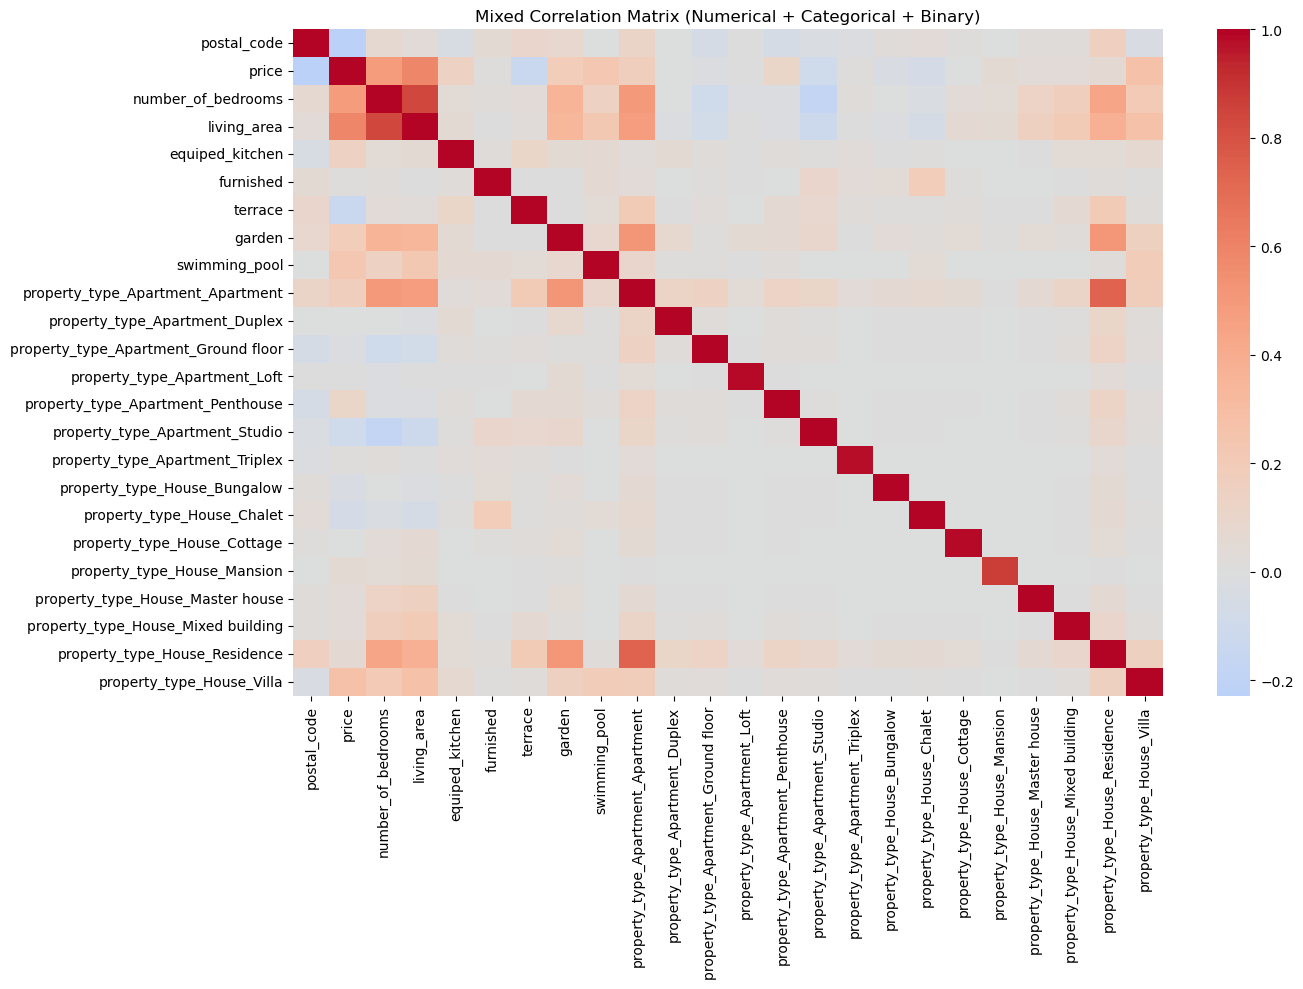

In [39]:
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix.astype(float), annot=False, cmap="coolwarm", center=0)
plt.title("Mixed Correlation Matrix (Numerical + Categorical + Binary)")
plt.tight_layout()
plt.show()